In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

nside = 2048
fov = [-10,10]

## File paths

In [2]:
datapath = './'
tplfa = datapath+'lensed_alm.fits'
tpulfa = datapath+'unlensed_alm.fits'
pkszf = datapath+'4e3_2048_50_50_ksz.fits'

## Read maps

In [3]:
tpl = hp.alm2map(hp.read_alm(tplfa),nside=nside)
tpul = hp.alm2map(hp.read_alm(tpulfa),nside=nside)
pksz = hp.ud_grade(hp.read_map(pkszf),nside)

## Add (un-)lensed primary to secondary

In [4]:
tl = tpl + pksz
tul = tpul + pksz

## Wiener filter

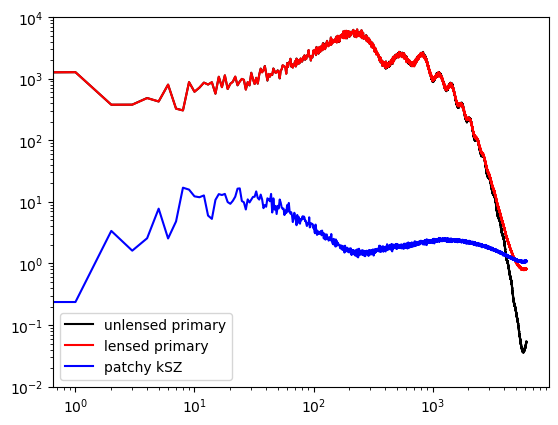

In [5]:
cl_tl = hp.anafast(tl,iter=0)
cl_tpl = hp.anafast(tpl,iter=0)
cl_tpul = hp.anafast(tpul,iter=0)
cl_pksz = hp.anafast(pksz,iter=0)

W = cl_pksz / (cl_pksz + cl_tl)
ellW = np.arange(len(W))

lmax = len(cl_tl) - 1
ell = np.arange(lmax+1)[1:]

cl_tl = cl_tl[1:lmax+1]
cl_tpl = cl_tpl[1:lmax+1]
cl_tpul = cl_tpul[1:lmax+1]
cl_pksz = cl_pksz[1:lmax+1]

plt.loglog(ell**2*cl_tpul/2/np.pi,c='k',label='unlensed primary')
plt.loglog(ell**2*cl_tpl/2/np.pi,c='r',label='lensed primary')
plt.loglog(ell**2*cl_pksz/2/np.pi,c='b',label='patchy kSZ')

plt.gca().set_ylim([1e-2,1e4])
plt.legend()

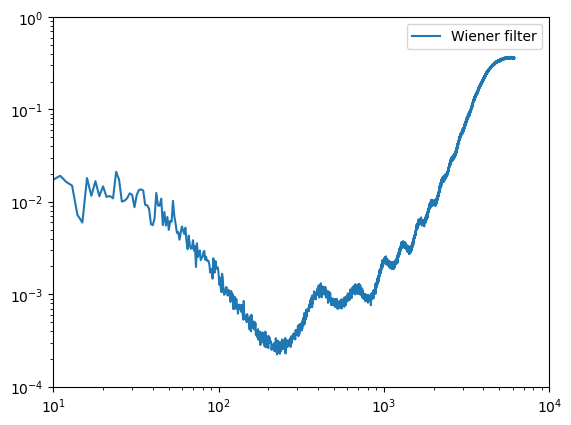

In [12]:
plt.loglog(ellW,W,label='Wiener filter')

plt.gca().set_xlim([10,1e4])
plt.gca().set_ylim([1e-4,1])
plt.legend()

## Filtering

In [14]:
def ell_filter(m,lmin,lmax,nside):
    ell = np.arange(lmax+1)
    fl = np.interp(ell,ellW,W)
    fl[ell<lmin] = 0
    fl[ell>lmax] = 0
    return hp.alm2map(hp.almxfl(hp.map2alm(m,iter=0),fl),nside=nside)

lmin = 3000
lmax = 5000

tl_hpass = ell_filter(tl,lmin,lmax,nside)
tpl_hpass = ell_filter(tpl,lmin,lmax,nside)
tpul_hpass = ell_filter(tpul,lmin,lmax,nside)
tul_hpass = ell_filter(tul,lmin,lmax,nside)
pksz_hpass = ell_filter(pksz,lmin,lmax,nside)

## Gaussian random fields

In [15]:
tl_hpass_grf = hp.synfast(hp.anafast(tl_hpass,iter=0),nside=nside)
tpl_hpass_grf = hp.synfast(hp.anafast(tpl_hpass,iter=0),nside=nside)
tpul_hpass_grf = hp.synfast(hp.anafast(tpul_hpass,iter=0),nside=nside)
tul_hpass_grf = hp.synfast(hp.anafast(tul_hpass,iter=0),nside=nside)
pksz_hpass_grf = hp.synfast(hp.anafast(pksz_hpass,iter=0),nside=nside)

## Squared field power spectra

In [16]:
cl_tul2 = hp.anafast(tul_hpass**2,iter=0)
cl_tl2 = hp.anafast(tl_hpass**2,iter=0)
cl_tpul2 = hp.anafast(tpul_hpass**2,iter=0)
cl_tpl2 = hp.anafast(tpl_hpass**2,iter=0)
cl_pksz2 = hp.anafast(pksz_hpass**2,iter=0)

cl_tul2_grf = hp.anafast(tul_hpass_grf**2,iter=0)
cl_tl2_grf = hp.anafast(tl_hpass_grf**2,iter=0)
cl_tpul2_grf = hp.anafast(tpul_hpass_grf**2,iter=0)
cl_tpl2_grf = hp.anafast(tpl_hpass_grf**2,iter=0)
cl_pksz2_grf = hp.anafast(pksz_hpass_grf**2,iter=0)

lmax = len(cl_tl2) - 1
ell = np.arange(lmax+1)[1:]

cl_tl2 = cl_tl2[1:lmax+1]
cl_tul2 = cl_tul2[1:lmax+1]
cl_tpl2 = cl_tpl2[1:lmax+1]
cl_tpul2 = cl_tpul2[1:lmax+1]
cl_pksz2 = cl_pksz2[1:lmax+1]

cl_tl2_grf = cl_tl2_grf[1:lmax+1]
cl_tul2_grf = cl_tul2_grf[1:lmax+1]
cl_tpl2_grf = cl_tpl2_grf[1:lmax+1]
cl_tpul2_grf = cl_tpul2_grf[1:lmax+1]
cl_pksz2_grf = cl_pksz2_grf[1:lmax+1]

## Show power spectra residuals with respect to GRF

(1e-08, 0.002)

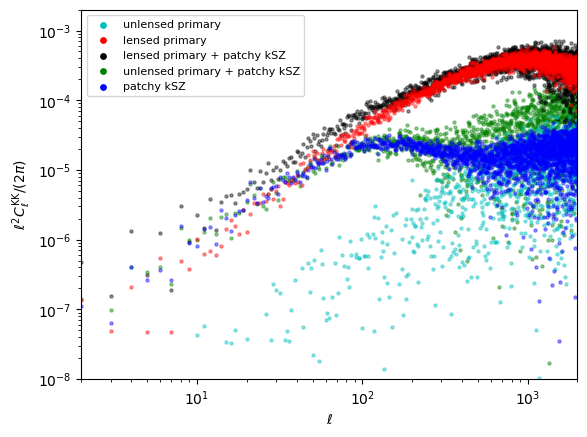

In [94]:
alpha=0.4
s=5
plt.scatter(ell,ell**2*(cl_tul2-cl_tul2_grf)/2/np.pi,marker='o',s=s,alpha=alpha,c='g')
plt.scatter(ell,ell**2*(cl_tl2-cl_tl2_grf)/2/np.pi,marker='o',s=s,alpha=alpha,c='k')
plt.scatter(ell,ell**2*(cl_tpl2-cl_tpl2_grf)/2/np.pi,marker='o',s=s,alpha=alpha,c='r')
plt.scatter(ell,ell**2*(cl_tpul2-cl_tpul2_grf)/2/np.pi,marker='o',s=s,alpha=alpha,c='c')
plt.scatter(ell,ell**2*(cl_pksz2-cl_pksz2_grf)/2/np.pi,marker='o',s=s,alpha=alpha,c='b')

plt.scatter(1e50,1e50,marker='.',s=60,c='c',label='unlensed primary')
plt.scatter(1e50,1e50,marker='.',s=60,c='r',label='lensed primary')
plt.scatter(1e50,1e50,marker='.',s=60,c='k',label='lensed primary + patchy kSZ')

plt.scatter(1e50,1e50,marker='.',s=60,c='g',label='unlensed primary + patchy kSZ')
plt.scatter(1e50,1e50,marker='.',s=60,c='b',label='patchy kSZ')

plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

plt.gca().set_ylabel(r'$\ell^2C_\ell^{\rm KK}/(2\pi)$')
plt.gca().set_xlabel(r'$\ell$')
plt.legend(fontsize=8)
plt.gca().set_xlim([2,2e3])
plt.gca().set_ylim([1e-8,2e-3])